In [1593]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pyperclip

In [1594]:
dt = 0.05
s  = ctl.TransferFunction.s

In [1595]:
C = s/(dt*s + 1)
C

TransferFunction(array([1, 0]), array([0.05, 1.  ]))

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [1596]:
C_z = ctl.c2d(C, dt, method='zoh')
C_z

TransferFunction(array([ 20., -20.]), array([ 1.        , -0.36787944]), 0.05)

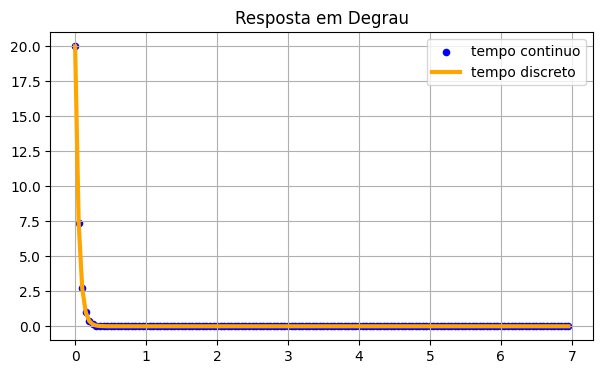

In [1597]:
tData = np.arange(0, 7, dt)
plt.figure(figsize=(7, 4))

time, continuous = ctl.step_response(C, T=tData)
time, digital    = ctl.step_response(C_z, T=tData)
plt.scatter(time, continuous, color='blue', s=20, label='tempo continuo')
plt.plot(time, digital, color='orange', linewidth=3, label='tempo discreto')
plt.grid(), plt.legend(), plt.title('Resposta em Degrau')
plt.show()

# DIGITALIZANDO O SISTEMA
- Preparando as funções que permitem digitalizar a função de transferência em transformada $Z$
    - **printDigital**: Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada
    - **compute**: aplica a função digitalizada a partir dos estados anteriores

- Estados anteriores
    - Y[0], Y[1], Y[2] ... se referem aos estados $Y_n$ (saída atual), $Y_{n-1}$ (penúltima saída), $Y_{n-2}$ (antipenúltima saída)

In [1598]:
def getFraction(G_z):
    num, den = ctl.tfdata(G_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]

    if type(num) == np.float64:
        num = np.array([num])

    num = [float(val) for val in num]
    den = [float(val) for val in den]
    return (num, den) 


num, den = getFraction(C_z)
print(f'num -> xSize={len(num)}')
print(f'den -> ySize={len(den)}')

num -> xSize=2
den -> ySize=2


In [1599]:
def printDigital(num, den):
    out = ''
    
    for i in range(0, len(num)): 
        out += f'Xn{i}*({num[i]:.6f}) + '

    for i in range(1, len(den)): 
        out += f'Yn{i}*({-1*den[i]:.6f}) + '
    
    out = out.replace('Xn0', 'Xn')[:-3] + ';'
    pyperclip.copy(out)
    print(out)


printDigital(num, den)

Xn*(20.000000) + Xn1*(-20.000000) + Yn1*(0.367879);


# OBJETO SISTEMA

In [1600]:
class StatesUpdater:
    buffer  = None
    initial = 0
    size    = 0

    def __init__(self, size, initial=0):
        self.initial = initial
        self.size    = size
        self.buffer  = initial * np.ones(size)
        
    def update(self, value=None):
        for i in range(self.size-1, 0, -1):
            self.buffer[i] = self.buffer[i-1]
        
        self.setFirst(value)
        return self.buffer
    
    def setFirst(self, value):
        if value is not None:
            self.buffer[0] = value

    def reset(self):
        for i in range(self.size): self.buffer[i] = self.initial
    

states = StatesUpdater(3)
for i in range(1, 5): print(states.update(i))

[1. 0. 0.]
[2. 1. 0.]
[3. 2. 1.]
[4. 3. 2.]


In [1601]:
class DigitalSystem:
    def __init__(self, num, den, dt=0.05, bounds=None):
        self.bounds = bounds if bounds is not None else (-9e12, 9e12)
        self.num = num
        self.den = den
        self.dt  = dt
        self.Xn  = StatesUpdater(size=len(num))
        self.Yn  = StatesUpdater(size=len(den))

    def compute(self):
        out = 0.0
        
        for i in range(0, self.Xn.size): 
            out += self.Xn.buffer[i]*(self.num[i])
        
        for i in range(1, self.Yn.size):
            out += self.Yn.buffer[i]*(-1*self.den[i])
        
        if out > self.bounds[1]:
            out = self.bounds[1]
        
        if out < self.bounds[0]:
            out = self.bounds[0]
        
        return out

    def update(self, input):
        self.Xn.update(input)
        self.Yn.update()

        output = self.compute()
        self.Yn.setFirst(output)
        return output
    
    def control(self, input, setpoint):
        return self.update(setpoint - input)
    
    def reset(self):
        self.Xn.reset(), self.Yn.reset()
    

system = DigitalSystem(num, den, dt)

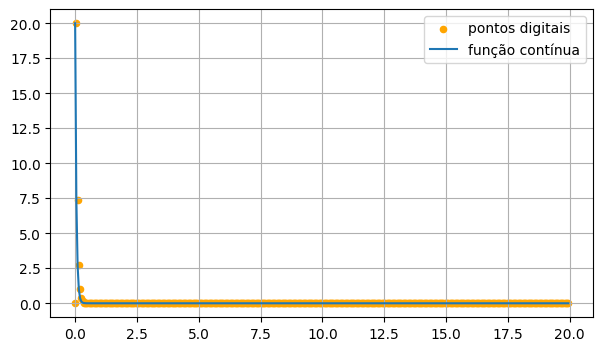

In [1602]:
time    = np.arange(0, 20, dt)
digital = [0.0] + [system.update(1) for k in range(1, len(time))]
time, continuous = ctl.step_response(C, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, digital, label='pontos digitais', color='orange', s=20)
plt.plot(time, continuous, label='função contínua')
plt.grid(), plt.legend()
plt.show()

# CÓDIGO DE MÁQUINA

In [1603]:
class Derivative:
    Xn1 = 0
    Yn1 = 0

    def __init__(self, dt=0.05):
        self.dt = dt
        s = ctl.TransferFunction.s
        C   = s/(dt*s + 1)
        C_z = ctl.c2d(C, dt, method='tustin')
        
        num, den = ctl.tfdata(C_z)
        num = np.squeeze(num)
        den = np.squeeze(den)

        num = num/den[0]
        den = den/den[0]

        if type(num) == np.float64:
            num = np.array([num])

        num = [float(val) for val in num]
        den = [float(val) for val in den]
        out = ''
        
        for i in range(0, len(num)): 
            out += f'Xn{i}*({num[i]:.6f}) + '

        for i in range(1, len(den)): 
            out += f'Yn{i}*({-1*den[i]:.6f}) + '
        
        out = out.replace('Xn0', 'Xn')[:-3]
        print(out)
        self.out = out
    
    def update(self, Xn):
        Xn1, Yn1 = self.Xn1, self.Yn1
        Yn = eval(self.out)
        self.Xn1 = Xn
        self.Yn1 = Yn
        return Yn
    
    def apply(self, yData):
        N = len(yData)
        response = np.zeros(N)
        self.reset()

        for x in range(N):
            response[x] = self.update(yData[x])

        return response

    def reset(self):
        self.Xn1 = 0
        self.Yn1 = 0

# TESTE CONTÍNUO
$f(x) = x^2$

In [1604]:
from sympy import symbols, diff, lambdify, cos

In [1605]:
dt = 0.015
a  = 2
b  = 10

- Sympy (contínuo)

In [1606]:
x = symbols('x')
f = 5/x
f

5/x

In [1607]:
xData = np.arange(a, b, dt)
fData = [f.subs(x, t) for t in xData]

In [1608]:
d = diff(f, x)
d

-5/x**2

In [1609]:
d = lambdify(x, d, 'numpy')
d

<function _lambdifygenerated(x)>

In [1610]:
ySympy = d(xData)

- laplace (discreto)

In [1611]:
derivative = Derivative(dt)
yModel = [derivative.update(x) for x in fData]

Xn*(44.444444) + Xn1*(-44.444444) + Yn1*(0.333333)


- Comparação

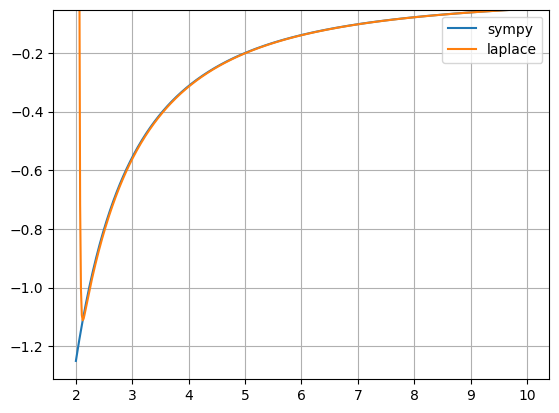

In [1612]:
plt.plot(xData, ySympy, label='sympy')
plt.plot(xData, yModel, label='laplace')
plt.grid(), plt.legend(), plt.ylim(min(ySympy)*1.05, max(ySympy)*1.05)
plt.show()